In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "test.csv" with length 2331766 bytes
User uploaded file "train.csv" with length 4794242 bytes


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
# setup tokenizer

vocab = Counter()

def text_to_wordlist(text, lower=False):
  text = tokenizer.tokenize(text)
  text = [w for w in text if len(w) != 1]
  vocab.update(text)
  return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)

    return comments

list_sentences_train = list(train_df["abstract"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["abstract"].fillna("NAN_WORD").values)

#Todas las keywords
comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

 21%|██        | 1125/5417 [00:00<00:00, 11246.71it/s]

Processing text dataset


100%|██████████| 5417/5417 [00:00<00:00, 10384.37it/s]


In [5]:
from gensim.models.fasttext import FastText

model = FastText(comments, size=300, window=5, min_count=5, workers=16, sg=1)

In [6]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 11043


In [7]:
#Definimos el tamaño de los vectores. Al estar trabajando con keywords podemos escoger un tamaño que no sea muy grane
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 30

from keras.preprocessing.sequence import pad_sequences

#Diccionario con todas las palabras asignadas un i + 1. 
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TRAIN)
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TEST)
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# Mediante la funcion pad_sequences recortamos los vectores de keywords a una longitud determinada, en este caso 20. 
#Ajuste del tamaño para TRAIN
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["Cardio", "Diges", "Resp", "Nerv", "Infe"]
y = train_df[list_classes].values
print('Shape de los tensores training (data):', data.shape)
print('Shape de los tensores label del training (y):', y.shape)

#Ajuste del tamaño para TEST
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post",
                          truncating="post")
print('Shape de los tensores del test (test_data):', test_data.shape)

Shape de los tensores training (data): (3629, 30)
Shape de los tensores label del training (y): (3629, 5)
Shape de los tensores del test (test_data): (1788, 30)


In [10]:
# Preparacion de la embedding matrix

WV_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

#hacemos la embedding matrix con los vectores del word2vec
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass 

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, LSTM, BatchNormalization
from keras.layers import  GlobalMaxPool1D, SpatialDropout1D
from keras.layers import Bidirectional
from keras.models import Model
from keras import optimizers

# Embedding layer for text inputs
input_words = Input((MAX_SEQUENCE_LENGTH, ))
x_words = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)(input_words)

x_words = SpatialDropout1D(0.1)(x_words)
x_words = LSTM(128, return_sequences=True)(x_words)
x_words = Dropout(0.1)(x_words)
x_words = Conv1D(64, 2, activation='relu', )(x_words)
x_words = GlobalMaxPool1D()(x_words)
x_words = Dropout(0.1)(x_words)

x = Dense(32, activation="relu")(x_words)
x = Dropout(0.1)(x)
preds = Dense(5, activation="softmax")(x)

model_2 = Model(inputs=[input_words], outputs=preds)
model_2.compile(loss='mae',
              optimizer='rmsprop',
              metrics=['accuracy']) 

In [ ]:
model.summary() 

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 300)           1074000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 256)           439296    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 29, 128)           65664     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)              

In [17]:
LSTMCNN_abstract_fasttext_ = model_2.fit([data], y, validation_split=0.1,
                 epochs=50, batch_size=150, shuffle=True)

Epoch 1/50
22/22 [==============================] - 11s 374ms/step - loss: 0.3188 - accuracy: 0.2085 - val_loss: 0.3043 - val_accuracy: 0.2342
Epoch 2/50
22/22 [==============================] - 4s 189ms/step - loss: 0.2887 - accuracy: 0.2813 - val_loss: 0.2884 - val_accuracy: 0.2755
Epoch 3/50
22/22 [==============================] - 4s 180ms/step - loss: 0.2783 - accuracy: 0.3063 - val_loss: 0.2824 - val_accuracy: 0.2865
Epoch 4/50
22/22 [==============================] - 4s 181ms/step - loss: 0.2713 - accuracy: 0.3222 - val_loss: 0.2797 - val_accuracy: 0.2920
Epoch 5/50
22/22 [==============================] - 4s 182ms/step - loss: 0.2718 - accuracy: 0.3199 - val_loss: 0.2682 - val_accuracy: 0.3444
Epoch 6/50
22/22 [==============================] - 4s 182ms/step - loss: 0.2561 - accuracy: 0.3675 - val_loss: 0.2582 - val_accuracy: 0.3609
Epoch 7/50
22/22 [==============================] - 4s 181ms/step - loss: 0.2514 - accuracy: 0.3750 - val_loss: 0.2790 - val_accuracy: 0.3085
Epoch

KeyboardInterrupt: ignored

In [ ]:
train_loss = np.mean(word2vec_ads.history['loss'])
val_loss = np.mean(word2vec_ads.history['val_loss'])
print('Train loss: %f' % (train_loss*100))
print('Validation loss: %f' % (val_loss*100))

Train loss: 16.414037
Validation loss: 15.327026


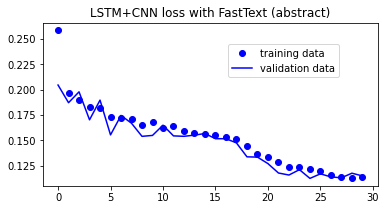

In [13]:
history = pd.DataFrame(LSTMCNN_abstract_fasttext.history)
plt.figure(figsize=(6,3));
plt.plot(history["loss"], 'bo', label='training data'); #puntos
plt.plot(history["val_loss"], 'b', label='validation data'); #linea
plt.title("LSTM+CNN loss with FastText (abstract)");
plt.legend(bbox_to_anchor=(0.9, 0.9))
plt.show();

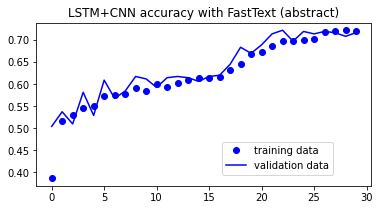

In [15]:
history = pd.DataFrame(LSTMCNN_abstract_fasttext.history)
plt.figure(figsize=(6,3));
plt.plot(history["accuracy"], 'bo', label='training data'); #puntos
plt.plot(history["val_accuracy"], 'b', label='validation data'); #linea
plt.title("LSTM+CNN accuracy with FastText (abstract)");
plt.legend(bbox_to_anchor=(0.9, 0.3))
plt.show();